# **Estrazione Embeddings e Attention Heads da un Transformer Model**

Nel seguente notebook, vedremo come estrarre le rappresentazioni interne (word/sentence embeddings) e le attention heads da un Transformer model.

 ## **Architettura di BERT**

 BERT (Devlin et al, 2019, https://aclanthology.org/N19-1423.pdf), nella sua versione base, è un Transformer Encoder model con i seguenti parametri:


*   **Layers**: 12;
*   **Attention heads per layer**: 12;
*  **Hidden units**: 768.





<div>
  <img src="https://media.geeksforgeeks.org/wp-content/uploads/20200420231335/elmo-eemmbeddings.jpg">
</div>

## **Librerie**

Di seguito vengono installate e importate le librerie da utilizzare.

In [ ]:
!pip install transformers

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch

# Libreria transformers per utilizzare i Transformer models
from transformers import AutoTokenizer, AutoModel

## **Caricamento del modello** ##

Di seguito, tramite la libreria *transformers* di Huggingface, carichiamo il nostro Transformer model.
Il modello ci servirà sia per l'addestramento sia per il caricamento del tokenizzatore con il quale preprocesseremo i nostri dati.

Quando carichiamo un modello abbiamo due possibilità:
- caricare un modello già esistente e disponibile su Huggingface.
In tal caso basterà scrivere il nome del modello da quelli disponibili qui: https://huggingface.co/models);
- caricare un modello che ho in locale (e.g. un modello che ho precedentemente fine-tunato su un alto task e voglio riutilizzare. In tal caso, basterà specificare il percorso fino alla cartella contenente il mio modello

In [ ]:
# Creo una variabile 'model' dove specificherò il modello da utilizzare
model_name = 'dbmdz/bert-base-italian-cased'

# Carico il modello
model = AutoModel.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)

# Carico il tokenizzatore
tokenizer = AutoTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/235k [00:00<?, ?B/s]

## **Estrazione delle Rappresentazioni + Attention Heads** ##

Di seguito, data una frase di input d'esempio, estraiamo dagli strati interni del nostro modello le sue rappresentazioni (word embeddings) e le attention heads.

Prima però di poter accedere al modello, dobbiamo tokenizzare la nostra frase, al fine di poterla poi passare al modello

In [ ]:
frase_input = "Il cane gioca con la sua amica."

tokens = tokenizer.tokenize(frase_input, add_special_tokens=True)
input_ids = tokenizer.encode(frase_input, add_special_tokens=True)

print("Tokens:", tokens)
print("Token Ids:", input_ids)

Tokens: ['[CLS]', '150', '##1', '+', '1500', '=', '300', '##1', '[SEP]']
Token Ids: [102, 6391, 30904, 2765, 18687, 4445, 5392, 30904, 103]


Dopo aver tokenizzato la frase, possiamo passarla al modello ed ottenere il suo output.
I parametri *output_hidden_states=True* e *output_attentions=True* settati precedentemente al momento del caricamento del modello servono per estrarre:
- le rappresentazioni di tutti gli strati interni (*output_hidden_states=True*)
- le attention heads (*output_attentions=True*)

In [ ]:
input_ids = torch.tensor([input_ids])

with torch.no_grad():
  outputs = model(input_ids)

all_hidden_states = outputs["hidden_states"]
attention_heads = outputs["attentions"]

### **Estrazione delle Rappresentazioni** ###

La variabile *all_hidden_states* contiene le rappresentazioni di tutti i token della nostra frase per ogni strato del modello (+ embedding layer).

Nel nostro caso, avremo quindi 12 + 1 strati (12 strati del modello + embedding layer)

In [ ]:
n_strati = len(all_hidden_states)
print("Numero degli strati:", n_strati)
print()

layer = 5

# Rappresentazioni dello strato = layer
hidden_state = all_hidden_states[layer]
print(hidden_state)
print()

dim_hidden_state = hidden_state.shape
print("Dimensione del tensore:", dim_hidden_state)

Numero degli strati: 13

tensor([[[-0.1118, -0.1993,  0.3608,  ...,  0.1732, -0.1014, -0.1119],
         [ 0.2811, -0.0904,  0.6190,  ...,  0.0205, -0.2130,  0.2634],
         [ 0.0658, -0.2447,  0.2812,  ..., -0.0626,  0.1223, -0.0305],
         ...,
         [-0.0939, -0.6563,  0.8471,  ...,  0.4987, -1.1710, -0.0695],
         [-0.2030, -0.2296,  0.1296,  ..., -0.1818, -0.1176, -0.0891],
         [ 0.0041, -0.0459,  0.0531,  ..., -0.0145, -0.1703,  0.0274]]])

Dimensione del tensore: torch.Size([1, 12, 768])


In [ ]:
embeddings_frase = hidden_state[0]

# Associo i token della frase alle corrispettive rappresentazioni
word_embeddings = {k:v for k, v in zip(tokens, embeddings_frase)}

print(word_embeddings["amica"])

tensor([-9.3932e-02, -6.5630e-01,  8.4706e-01,  4.2956e-01,  5.0574e-01,
        -5.0794e-02,  3.5416e-02,  7.1095e-01, -1.1559e+00, -2.7587e-01,
        -7.2745e-01, -1.8310e-01,  1.4529e-01,  2.0565e-01,  4.7341e-01,
        -1.6362e-01,  8.3303e-02,  1.2957e+00,  8.8574e-02, -5.6457e-01,
        -2.5629e-01,  5.5340e-01, -6.1050e-02, -4.6840e-01,  9.0956e-01,
         2.2774e-01,  5.5641e-01, -6.8970e-01, -1.1234e-01,  3.5121e-01,
        -1.9591e-01, -3.7160e-01,  9.7673e-01, -3.5026e-01, -1.2210e-01,
         5.7640e-01, -5.2751e-01,  1.5243e-01, -9.2748e-01, -5.5958e-01,
         1.7576e-01, -2.1403e-01,  1.0792e-01, -2.4632e-01, -1.1084e-01,
        -1.8110e-02,  1.2500e-01,  3.0739e-01, -4.1913e-01,  5.0400e-01,
         7.3705e-02,  2.6240e-01, -6.6993e-02,  8.2625e-01,  4.9392e-01,
         1.7312e-01,  1.5194e-01, -5.1106e-01,  3.5070e-01,  3.0548e-01,
        -8.7823e-02, -3.7122e-01, -6.6695e-03,  4.0111e-01,  2.5052e-01,
         4.4749e-01, -5.8391e-01, -2.2350e-01, -1.8

### **Estrazione e visualizzazione delle Attention Heads** ###

La variabile *attention_heads* contiene le attention matrices della frase analizzata.

BERT ha, per ogni strato, 12 matrici di attenzione. Questo fa sì che, ad ogni strato, ogni singolo token possa concentrarsi su 12 aspetti distinti degli altri token (e.g. relazioni sintattiche, semantiche, etc).

Ad esempio, se ci focalizziamo sul primo strato del modello, avremo in output una struttura con la seguente dimensione:

In [ ]:
layer = 1

attention_layer = attention_heads[layer]

print("Dimensione matrici di attention:", attention_layer.shape)

Dimensione matrici di attention: torch.Size([1, 12, 10, 10])


###**Layerwise Visualization**

Di seguito, visualizziamo le matrici di attenzione strato per strato, a partire da una delle 12 heads.

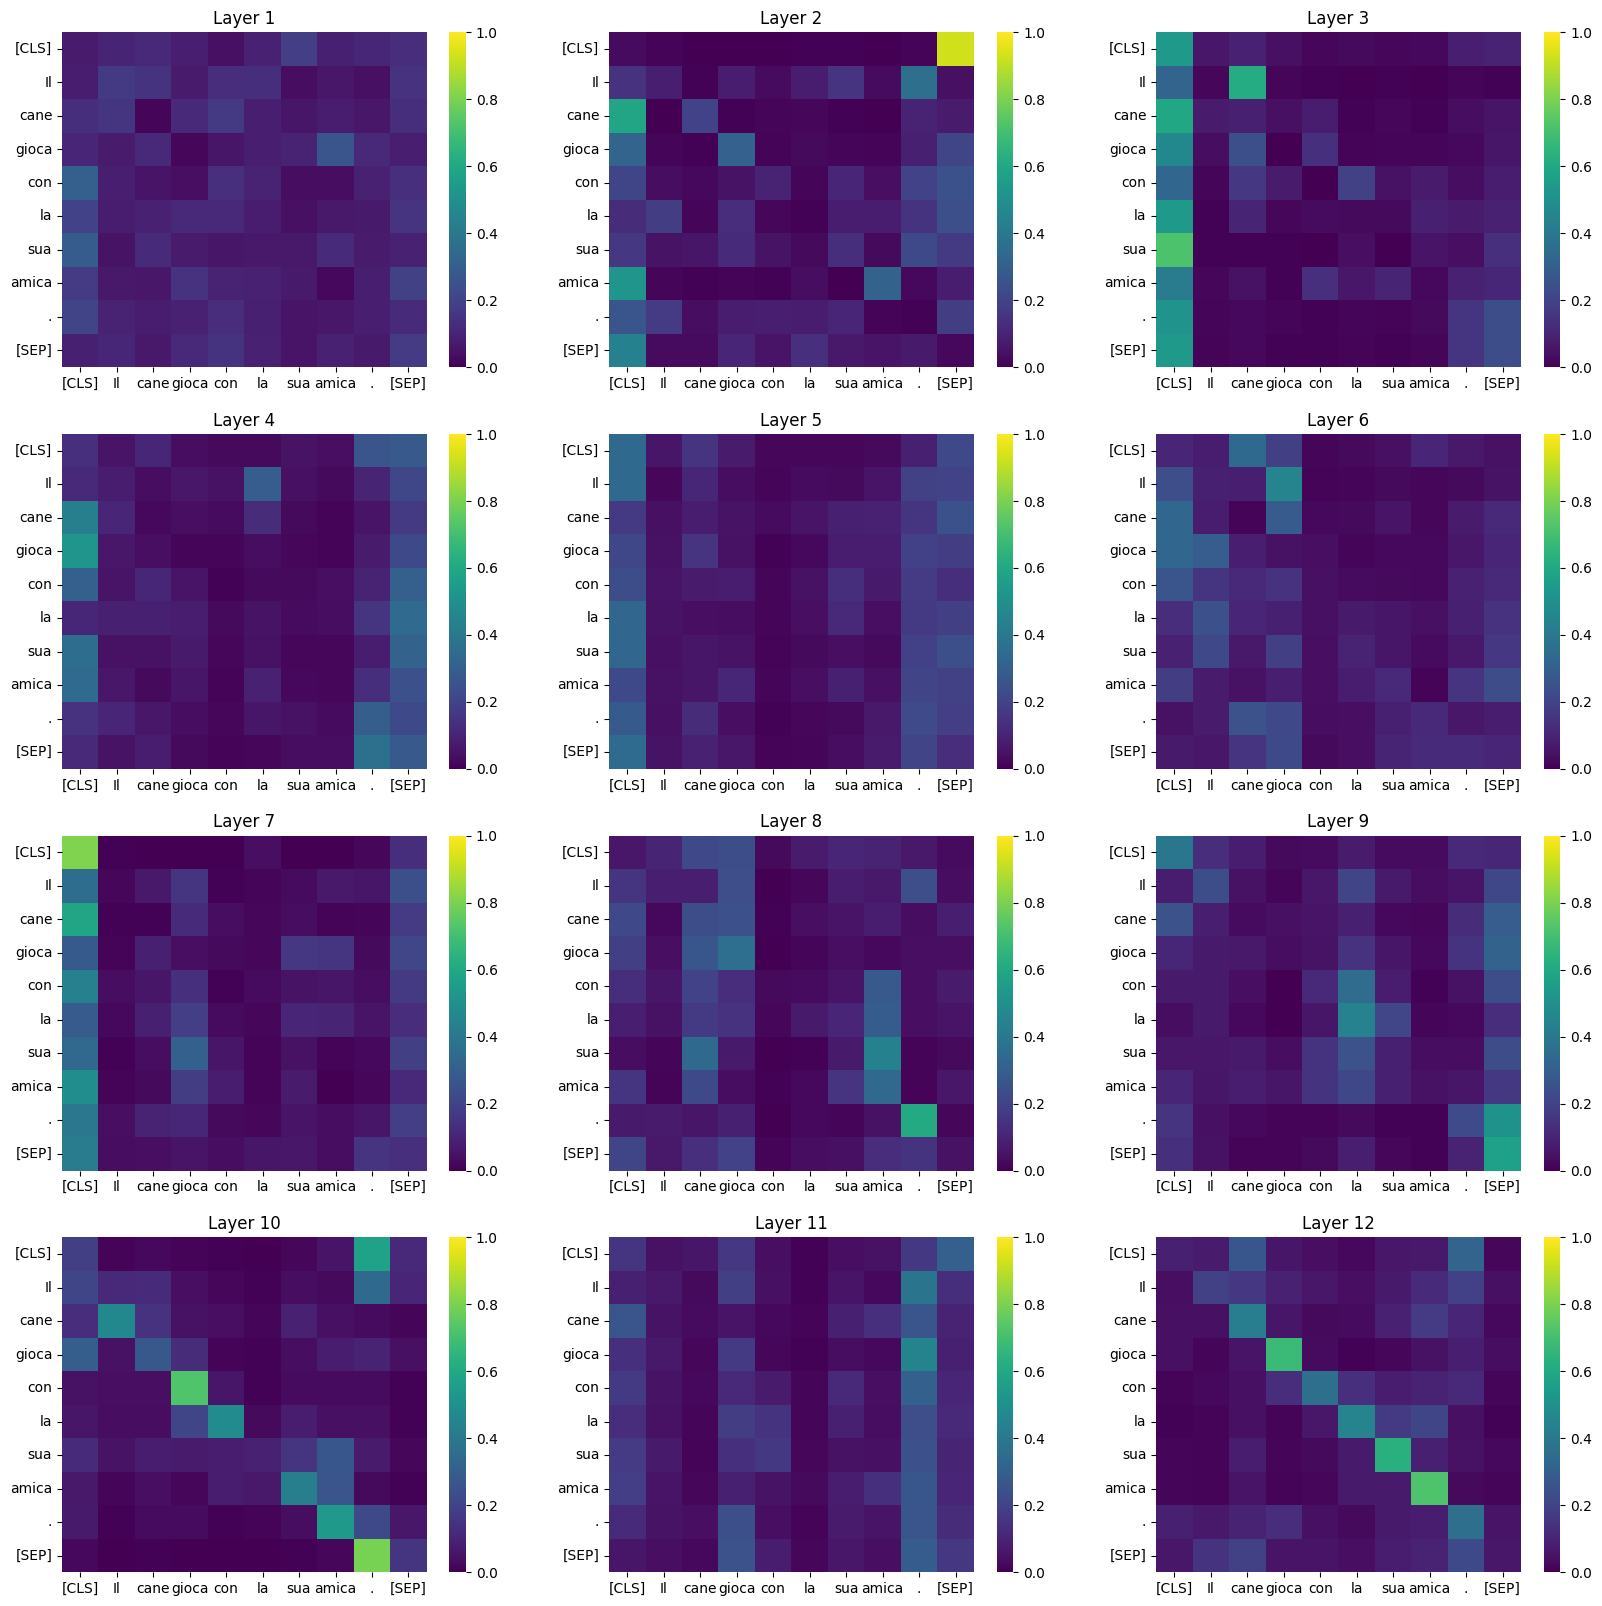

In [ ]:
head = 0

fig = plt.figure(figsize=(20, 20))

for idx, matrix in enumerate(attention_heads):

  # Accedo al primo elemento, siccome ho una sola frase
  matrix_sentence = matrix[0]

  # Accendo alla matrice con head uguale a quella selezionata
  head_matrix = matrix_sentence[head]

  # Nel caso volessimo visualizzare l'attention media e non quella di un'unica head, possiamo applicare la media fra le matrici delle 12 heads
  #head_matrix = torch.mean(matrix_sentence, 1)

  ax = fig.add_subplot(4, 3, idx+1)

  # Genero la matrice dell'attenzione della frase
  sns.heatmap(head_matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens, vmin=0, vmax=1)

  # Aggiungo il titolo ad ogni grafico
  ax.set_title('{} {}'.format("Layer", idx+1))


plt.show()

###***Headwise Visualization***

Di seguito, visualizziamo le matrici di attenzione head per head, a partire da uno dei 12 strati.

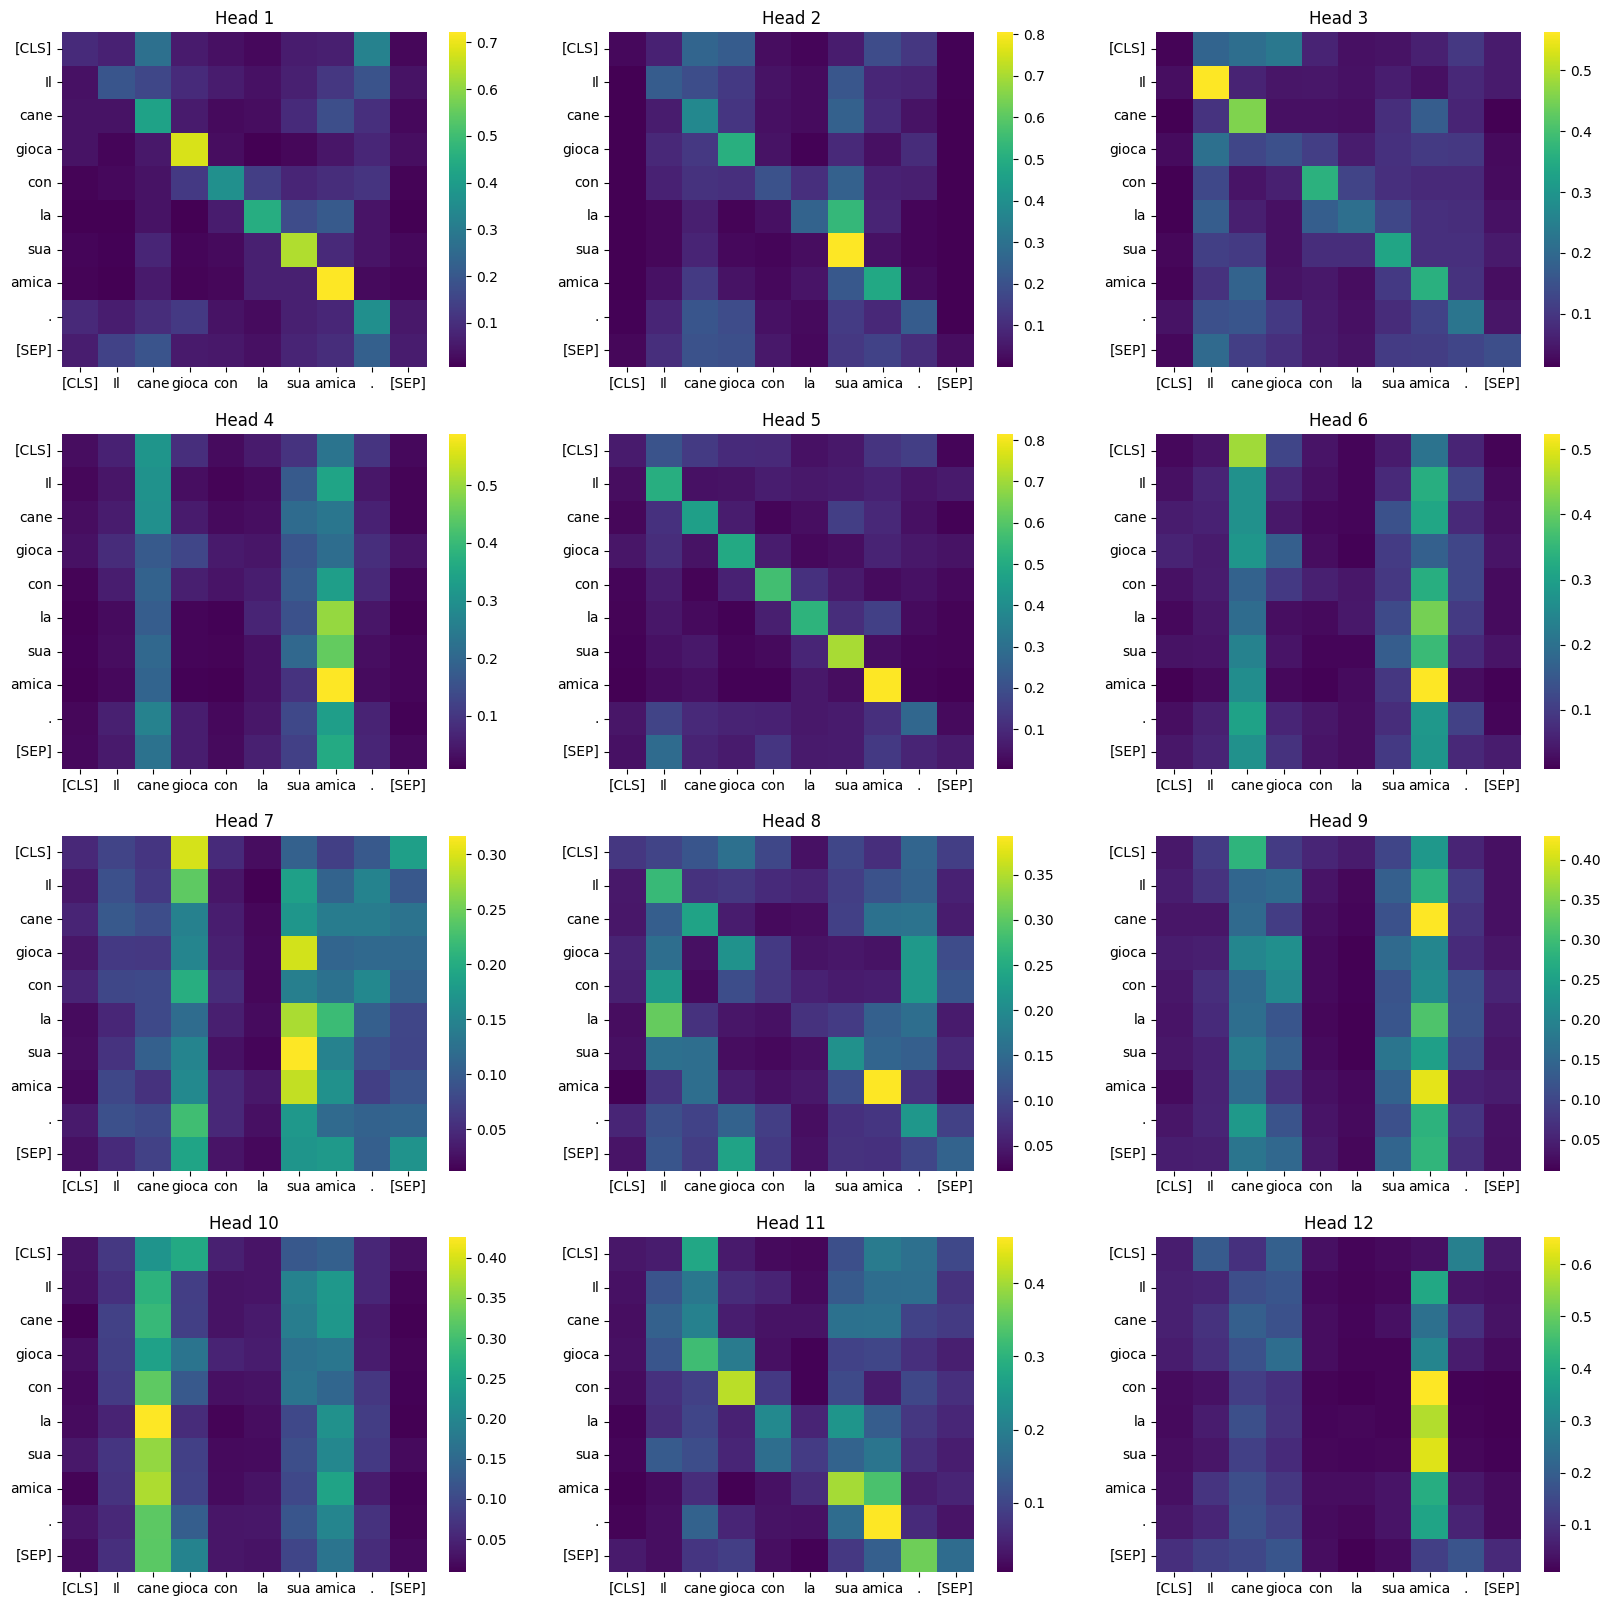

In [ ]:
layer = 11

fig = plt.figure(figsize=(20, 20))

# Prendo le 12 attention matrices dato lo strato selezionato
attention_layer = attention_heads[layer][0]

for idx, matrix in enumerate(attention_layer):
  ax = fig.add_subplot(4, 3, idx+1)

  # Genero la matrice dell'attenzione della frase
  sns.heatmap(matrix, cmap='viridis', yticklabels=tokens, xticklabels=tokens)

  # Aggiungo il titolo ad ogni grafico
  ax.set_title('{} {}'.format("Head", idx+1))


plt.show()